Preparación del entorno

In [6]:
# Instalación de librerías
%pip install "stable-baselines3[extra]" gymnasium

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importación de dependencias necesarias
import numpy as np
import joblib
from envs.attack_env import AttackEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

Funciones Auxiliares

In [8]:
# Clase callback personalizada para logear y graficar
class AttackLoggerCallback(BaseCallback): # Extiende BaseCallback de stable-baselines3

    def __init__(self, log_freq: int = 1000, verbose: int = 0): # Muestra estadísticas cada 1000 episodios y pone el nivel de verbosidad a 0 por defecto (no muestra nada)
        super().__init__(verbose) # Llamamos al constructor padre con el nivel de verbosidad
        self.log_freq = log_freq # Muestra estadísticas cada log_freq episodios
        self.episode_count = 0 # Contador de episodios completados

        # Buffers por ventana (1000 episodios)
        self.rewards_buffer = [] # Buffer para recompensas
        self.success_buffer = [] # Buffer de veces que tuvo éxito
        self.p_attack_buffer = [] # Buffer de probabilidades de que el detector detecte el ataque

        # Históricos completos para graficar
        self.history_episodes = []
        self.history_mean_reward = []
        self.history_success_rate = []
        self.history_mean_p_attack = []

    def _on_step(self) -> bool:

        # Extraemos la información relevante del entorno
        infos = self.locals["infos"] # Información devuelta por el entorno
        rewards = self.locals["rewards"] # Recompensas obtenidas
        dones = self.locals["dones"] # Si el episodio ha terminado

        # Iteramos sobre la información, recompensas y estados de finalización
        for info, r, done in zip(infos, rewards, dones):

            # Si el episodio ha terminado
            if done:
                self.episode_count += 1 #  Incrementamos el contador de episodios
                self.rewards_buffer.append(float(r)) # Guardamos la recompensa obtenida

                # Si hubo éxito en el ataque
                if "success" in info:
                    self.success_buffer.append(int(info["success"])) # Guardamos si tuvo éxito

                # Si se proporciona la probabilidad de detección del ataque
                if "p_attack" in info:
                    self.p_attack_buffer.append(float(info["p_attack"])) # Guardamos la probabilidad de detección del ataque

        # Cada log_freq episodios, mostramos las estadísticas
        if self.episode_count > 0 and self.episode_count % self.log_freq == 0:

            # Calculamos las métricas
            mean_reward = np.mean(self.rewards_buffer) if self.rewards_buffer else 0.0 # Recompensa media
            success_rate = np.mean(self.success_buffer) if self.success_buffer else 0.0 # Tasa de éxito
            mean_p_attack = np.mean(self.p_attack_buffer) if self.p_attack_buffer else 0.0 # Probabilidad media de detección del ataque

            # Guardamos las métricas en el histórico
            self.history_episodes.append(self.episode_count) # Episodios completados
            self.history_mean_reward.append(mean_reward) # Recompensa media
            self.history_success_rate.append(success_rate) # Tasa de éxito
            self.history_mean_p_attack.append(mean_p_attack) # Probabilidad media de detección del ataque

            # Mostramos las métricas por consola
            print(
                f"[AttackLogger] Episodios: {self.episode_count:6d} | "
                f"Reward medio: {mean_reward: .3f} | "
                f"Tasa éxito: {success_rate*100:5.1f}% | "
                f"p_attack media: {mean_p_attack: .3f}"
            )

            # Limpiamos los buffers para la siguiente ventana
            self.rewards_buffer.clear()
            self.success_buffer.clear()
            self.p_attack_buffer.clear()

        return True


In [ ]:
# Función para evaluar el desempeño del atacante
def evaluate_attacker(model, env, n_episodes=1000): # Modelo entrenado, entorno y número de episodios a evaluar
    
    # Variable para recuento
    successes = 0 # Contador de éxitos
    deltas_norm = [] # Lista para guardar las normas de las perturbaciones aplicadas (cuanto se ha modificado cada muestra)
 
    # Reseteamos el entorno para obtener la observación inicial
    obs, info = env.reset() 

    # Iteramos por el número de episodios a evaluar
    for _ in range(n_episodes): 

        # Obtenemos la acción del modelo (determinística, ahora queremos el mejor ataque posible no explorar)
        action, _ = model.predict(obs, deterministic=True)

        # Ejecutamos la acción en el entorno y obtenemos los resultados
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Si el ataque fue exitoso
        if info["success"] == 1:
            successes += 1 # Incrementamos el contador de éxitos

        # Calculamos la norma de la perturbación aplicada
        delta = info["x_adv"] - info["x_orig"]

        # Guardamos la norma de la perturbación
        deltas_norm.append(np.linalg.norm(delta))

        # Si el episodio ha terminado, reseteamos el entorno
        if terminated or truncated:
            obs, info = env.reset()
        # Sino, continuamos con la siguiente observación
        else:
            obs = next_obs

    # Calculamos las métricas finales
    success_rate = successes / n_episodes # Tasa de éxito, número de éxitos dividido por número de episodios
    mean_delta = float(np.mean(deltas_norm)) # Norma media de las perturbaciones aplicadas

    # Devolvemos la tasa de éxito y la norma media de las perturbaciones aplicadas  
    return success_rate, mean_delta 

In [15]:
# Función para evaluar el desempeño del atacante aleatorio
def evaluate_random_attacker(env, n_episodes=1000): # Entorno y número de episodios a evaluar

    # Variable para recuento
    successes = 0 # Contador de éxitos
    deltas_norm = [] # Lista para guardar las normas de las perturbaciones aplicadas (cuanto se ha modificado cada muestra)

    # Reseteamos el entorno para obtener la observación inicial
    obs, info = env.reset()

    # Iteramos por el número de episodios a evaluar
    for _ in range(n_episodes):

        # Seleccionamos una acción aleatoria
        action = env.action_space.sample()

        # Ejecutamos la acción en el entorno y obtenemos los resultados
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Si el ataque fue exitoso
        if info["success"] == 1:
            successes += 1 # Incrementamos el contador de éxitos

        # Calculamos la norma de la perturbación aplicada
        delta = info["x_adv"] - info["x_orig"]

        # Guardamos la norma de la perturbación
        deltas_norm.append(np.linalg.norm(delta))

        # Si el episodio ha terminado, reseteamos el entorno
        if terminated or truncated:
            obs, info = env.reset()
        # Sino, continuamos con la siguiente observación
        else:
            obs = next_obs

    # Calculamos las métricas finales
    success_rate = successes / n_episodes
    mean_delta = float(np.mean(deltas_norm))

    # Devolvemos la tasa de éxito y la norma media de las perturbaciones aplicadas  
    return success_rate, mean_delta

In [ ]:
# Función para muestrear ataques adversariales generados por el agente
def sample_adversarials(model, env, n_samples=200): # Entorno y número de muestras a generar

    # Listas para guardar los datos muestreados
    xs_orig = []
    xs_adv = []
    successes = []

    # Reseteamos el entorno para obtener la observación inicial
    obs, info = env.reset()

    # Iteramos para muestrear el número de ataques adversariales deseados
    for _ in range(n_samples):

        # Obtenemos la acción del modelo (determinística)
        action, _ = model.predict(obs, deterministic=True)

        # Ejecutamos la acción en el entorno y obtenemos los resultados
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Guardamos los datos relevantes de la información proporcionada por el entorno
        xs_orig.append(info["x_orig"])
        xs_adv.append(info["x_adv"])
        successes.append(info["success"])

        # Reseteamos el entorno
        obs, info = env.reset()

    # Devolvemos los arrays de datos muestreados
    return np.array(xs_orig), np.array(xs_adv), np.array(successes)

Creación del área de trabajo

In [10]:
# Carga del dataset
data = np.load("../data/synthetic_2d.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

# Cargamos solo muestras de ataque para el entorno
attack_mask = y_train == 1 # Crea un array booleano a true para muestras de ataque
attack_samples = X_train[attack_mask] # Nos quedamos solo con las muestras de ataque

# Imprimimos la forma de las muestras de ataque
print("Attack samples:", attack_samples.shape)

# Carga del modelo clasificador
clf = joblib.load("../classifiers/logreg_synthetic_2d.joblib")

Attack samples: (800, 2)


In [11]:
# Creación del entorno
env = AttackEnv(
    attack_samples=attack_samples, # Lista de todas las muestras de ataque
    clf=clf, # Modelo clasificador
    threshold=0.5, # A partid de de esta probabilidad se considera que es ataque
    epsilon=0.5, # Distancia máxima que el agente puede mofificar el punto original
    penalty=0.05, # Penalización por moverse mucho
)

Entrenamiento del agente

In [26]:
# Constucción y entrenamiento del agente PPO (RL)
policy_kwargs = dict(net_arch=[64, 64]) # Arquitectura de la red neuronal, dos capas ocultas de 64 neuronas cada una

model = PPO(
    "MlpPolicy",
    env, # Ligamos el modelo con el entorno
    verbose=0, # Indica imprimir información báscica del entrenamiento (1) o no (0)
    policy_kwargs=policy_kwargs, # Le pasamos la arquiectura definida para la red neuronal
    n_steps=2048, # Número de pasos a ejecutar antes de cada actualización de política
    batch_size=64,  # Los grupos en los que se divide cada actualización
    learning_rate=3e-4, # Tasa de aprendizaje, qué tanto se actualizan los pesos de la red neuronal en cada paso
)

# Creación del callback personalizado para logging
callback = AttackLoggerCallback(log_freq=1000)

# Entrenamiento del agente de 100,000 pasos y uso del callback para logging
model.learn(total_timesteps=100_000, callback=callback)

# Guardado del modelo entrenado
model.save("../agents/ppo_attacker_synthetic_2d")

[AttackLogger] Episodios:   1000 | Reward medio:  0.001 | Tasa éxito:   2.0% | p_attack media:  0.966
[AttackLogger] Episodios:   2000 | Reward medio: -0.005 | Tasa éxito:   1.3% | p_attack media:  0.969
[AttackLogger] Episodios:   3000 | Reward medio:  0.003 | Tasa éxito:   2.2% | p_attack media:  0.964
[AttackLogger] Episodios:   4000 | Reward medio:  0.002 | Tasa éxito:   2.1% | p_attack media:  0.964
[AttackLogger] Episodios:   5000 | Reward medio:  0.002 | Tasa éxito:   2.0% | p_attack media:  0.964
[AttackLogger] Episodios:   6000 | Reward medio:  0.007 | Tasa éxito:   2.5% | p_attack media:  0.958
[AttackLogger] Episodios:   7000 | Reward medio:  0.016 | Tasa éxito:   3.4% | p_attack media:  0.950
[AttackLogger] Episodios:   8000 | Reward medio:  0.019 | Tasa éxito:   3.7% | p_attack media:  0.950
[AttackLogger] Episodios:   9000 | Reward medio:  0.018 | Tasa éxito:   3.6% | p_attack media:  0.949
[AttackLogger] Episodios:  10000 | Reward medio:  0.021 | Tasa éxito:   3.9% | p_a

Gráficas

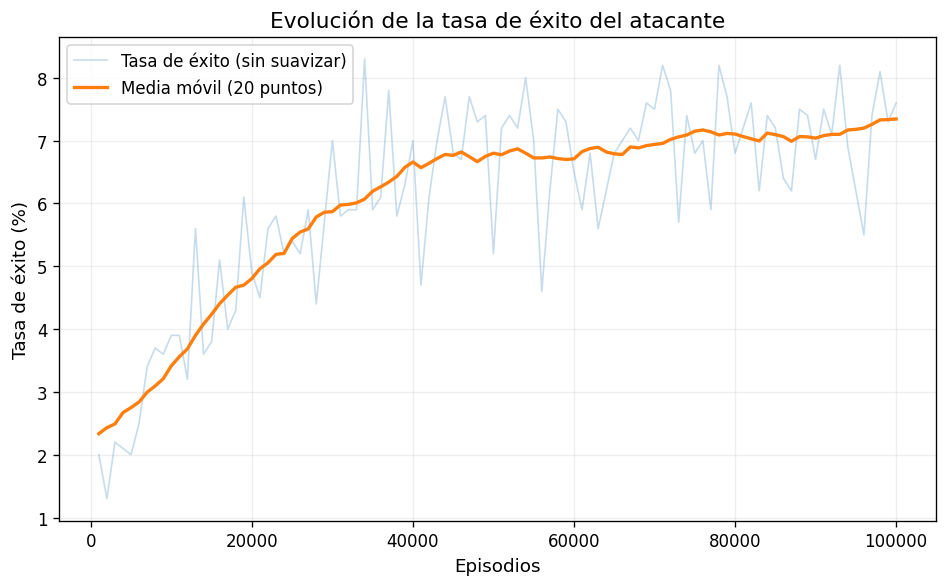

In [27]:
# Obtenemos los datos del callback
episodes = np.array(callback.history_episodes) # Número de episodios
success_rate = np.array(callback.history_success_rate) * 100  # Porcentaje de éxito

# Tamaño de la ventana para la media móvil (suavizado)
window = 20

# Configuración de los elementos para la media móvil
kernel = np.ones(window) / window # Kernel para la media móvil (calculado como la media de los últimos 'window' puntos)
half = window // 2 # Mitad de la ventana
padded = np.pad(success_rate, (half, window - 1 - half), mode="edge") # Padding para los bordes (replicando los valores de los extremos)
success_smooth = np.convolve(padded, kernel, mode="valid") # Convolución "limpia", corregimos los bordes
episodes_smooth = episodes  # La gráfica suavizada tendrá la misma longitud que los datos originales

# Configuración de la figura
plt.figure(figsize=(8, 5), dpi=120)

# Línea original (sin suavizar), semitransparente
plt.plot(
    episodes,
    success_rate,
    alpha=0.25,
    linewidth=1,
    label="Tasa de éxito (sin suavizar)",
)

# Línea suavizada con media móvil
plt.plot(
    episodes_smooth,
    success_smooth,
    linewidth=2.0,
    label=f"Media móvil ({window} puntos)",
)

# Etiquetas y estilo
plt.xlabel("Episodios", fontsize=11)
plt.ylabel("Tasa de éxito (%)", fontsize=11)
plt.title("Evolución de la tasa de éxito del atacante", fontsize=13)
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


Prueba de resultados

In [30]:
# Cargamos el modelo entrenado
model = PPO.load("../agents/ppo_attacker_synthetic_2d")

# Evaluamos el atacante entrenado con 2000 episodios y el modelo entrenado
success_rate, mean_delta = evaluate_attacker(model, env, n_episodes=2000)

# Mostramos los resultados de la evaluación final
print(f"Tasa de evasión: {success_rate*100:.3f}%")
print(f"Norma media de la perturbación: {mean_delta:.3f}")

Tasa de evasión: 7.250%
Norma media de la perturbación: 0.320


In [29]:
# Evaluamos un atacante aleatorio con 2000 episodios
rand_success, rand_delta = evaluate_random_attacker(env, n_episodes=2000)

# Mostramos los resultados de la evaluación final
print(f"[Random] Tasa de evasión: {rand_success*100:.3f}%")
print(f"[Random] Norma media de la perturbación: {rand_delta:.3f}")

[Random] Tasa de evasión: 1.300%
[Random] Norma media de la perturbación: 0.382


Conclusiones

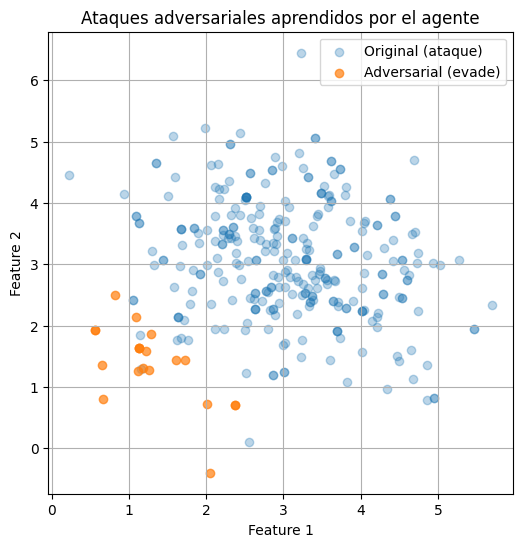

In [ ]:
# Muestreamos 300 ataques adversariales generados por el agente entrenado
xs_orig, xs_adv, successes = sample_adversarials(model, env, n_samples=300)

# Configuración de la gráfica
plt.figure(figsize=(6, 6))

# Pintamos los ataques originales de color azul claro
plt.scatter(xs_orig[:, 0], xs_orig[:, 1], alpha=0.3, label="Original (ataque)")

# Pintamos los ataques adversariales que lograron evadir el detector de color naranja
mask_ok = successes == 1
plt.scatter(xs_adv[mask_ok, 0], xs_adv[mask_ok, 1], alpha=0.7, label="Adversarial (evade)")
plt.legend()
plt.grid(True)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Ataques adversariales aprendidos por el agente")
plt.show()


Conclusiones

- Están claramente desplazados hacia la región de tráfico normal

- No se van demasiado lejos: usa perturbaciones pequeñas, significa que el agente NO hace cambios absurdos, sino justo los necesarios para engañar al clasificador.

- Están BIEN agrupados: No están dispersos por el plano a lo random. Se concentran en la región más baja del riesgo, lo que indica política aprendida basada en gradiente, no ruido.

- Los evade justo justo en los puntos donde la frontera entre normal/ataque era más cercana: Esto es EXACTAMENTE comportamiento adversarial: empujar la muestra hacia el lado “normal” más cercano, de la forma más eficiente posible.